In [16]:
import yfinance as yf
import pandas as pd

symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]

data = {}
for sym in symbols:
    data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")

print(data["AAPL"].head())


/tmp/ipython-input-2097320346.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2097320346.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2097320346.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2097320346.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 co

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.341888  40.351258  39.639313  39.850088  102223600
2018-01-03  40.334854  40.878181  40.271625  40.405112  118071600
2018-01-04  40.522205  40.625250  40.299724  40.407450   89738400
2018-01-05  40.983559  41.070208  40.526885  40.618220   94640000
2018-01-08  40.831337  41.126417  40.732973  40.831337   82271200


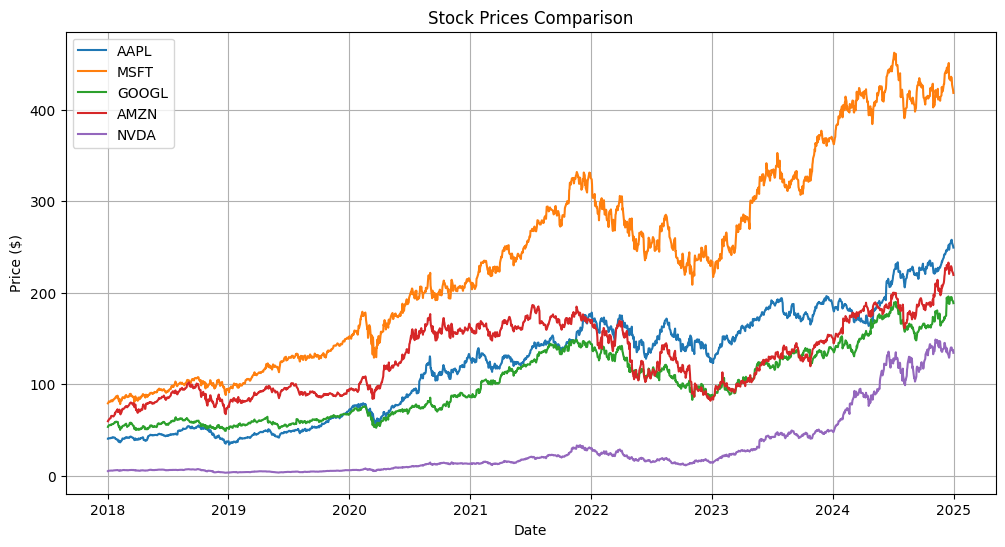

In [31]:
plt.figure(figsize=(12,6))

for sym in symbols:
    plt.plot(data[sym].index, data[sym]["Close"], label=sym)

plt.title("Stock Prices Comparison")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
for sym in symbols:
    df = data[sym]
    df["returns"] = df["Close"].pct_change()
    data[sym] = df.dropna()


In [33]:
for sym in symbols:
    df = data[sym]
    df["target"] = df["Close"].shift(-1)
    data[sym] = df.dropna()


In [34]:
from sklearn.metrics import mean_absolute_error

for sym in symbols:
    df = data[sym]
    mae = mean_absolute_error(df["target"], df["Close"])
    print(f"{sym} baseline MAE:", round(mae, 3))


AAPL baseline MAE: 1.572
MSFT baseline MAE: 2.897
GOOGL baseline MAE: 1.373
AMZN baseline MAE: 1.961
NVDA baseline MAE: 0.69
